## **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, LinearRegression
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, mean_squared_log_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, LabelBinarizer, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from catboost import CatBoostRegressor

from great_tables import GT, style ,exibble, from_column, loc
from colorama import Style, Fore

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
palette = ["d9ed92","b5e48c","99d98c","76c893","52b69a","34a0a4","168aad","1a759f","1e6091","184e77"]

config = {
    'SEED' : 42,
    'N_SPLITS': 5,
    'SUBMIT' : True,
    'USE_ORIGINAL': False
    
}

In [3]:
train = pd.read_csv('./data/train.csv')

In [4]:
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [5]:
train.shape

(1117957, 22)

In [6]:
train.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [7]:
train.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [8]:
test = pd.read_csv('./data/test.csv')

In [9]:
test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [10]:
test.shape

(745305, 21)

In [11]:
test.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
dtype: int64

In [12]:
test.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
count,7.453050e+05,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,...,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000
mean,1.490609e+06,4.915610,4.930288,4.960027,4.946084,4.938424,4.933524,4.958468,4.927651,4.945308,...,4.947436,4.944003,4.957209,4.927620,4.930720,4.926062,4.926957,4.948424,4.940204,4.943918
std,2.151512e+05,2.056295,2.094117,2.071722,2.052602,2.081816,2.059243,2.089312,2.068110,2.073404,...,2.081322,2.072335,2.088787,2.079006,2.083348,2.065638,2.073692,2.065891,2.079128,2.087387
min,1.117957e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.304283e+06,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,...,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000
50%,1.490609e+06,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,1.676935e+06,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,1.863261e+06,16.000000,17.000000,16.000000,17.000000,17.000000,17.000000,16.000000,16.000000,16.000000,...,16.000000,17.000000,17.000000,16.000000,16.000000,17.000000,19.000000,22.000000,16.000000,16.000000


In [13]:
original = pd.read_csv('./data/original.csv')

In [14]:
original.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [15]:
original.shape

(50000, 21)

In [16]:
original.isnull().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

## **FUNCTIONS**

**PrintINFO function**

In [17]:
def printInfo(df,train,test):
    print(f'{Style.BRIGHT}{Fore.YELLOW}SHAPE{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.shape}')
    print(f'{Style.BRIGHT}{Fore.GREEN} test:  {test.shape}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original:  {df.shape}')
    print(f'{Style.BRIGHT}{Fore.YELLOW}\nNULL VALUES{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.isnull().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {test.isnull().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original: {df.isnull().any().any()}')    
    print(f'{Style.BRIGHT}{Fore.YELLOW}\nDUPLICATES{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.duplicated().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {test.duplicated().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original: {df.duplicated().any().any()}')

In [18]:
printInfo(original,train,test)

SHAPE
 train: (1117957, 22)
 test:  (745305, 21)
 original:  (50000, 21)

NULL VALUES
 train: False
 train: False
 original: False

DUPLICATES
 train: False
 train: False
 original: False


**Statistics function**

In [19]:
def Statistic(df: pd.DataFrame(), categoric = False):
    num_cols = list(df._get_numeric_data())
    cat_cols = list(df.drop(num_cols,axis=1))
    if categoric:
        desc = pd.DataFrame(index = list(df[cat_cols]))
        df = df[cat_cols]
    else:
        desc = pd.DataFrame(index = list(df[num_cols]))
        df = df[num_cols]
        desc['skew'] = df[num_cols].skew()
        
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] /len(df) * 100 
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc,df.describe().T.drop('count',axis=1)],axis=1)    

    desc = desc.round(2)
    return desc.reset_index().rename(columns={'index':'Column'}).sort_values(by=['type'])

In [20]:
Statistic(original)

,Column,skew,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
0,MonsoonIntensity,0.44,int64,50000,17,0.03,0,0.0,4.99,2.24,0.00,3.00,5.0,6.00,16.00
18,InadequatePlanning,0.46,int64,50000,17,0.03,0,0.0,4.99,2.23,0.00,3.00,5.0,6.00,16.00
17,WetlandLoss,0.44,int64,50000,19,0.04,0,0.0,5.01,2.23,0.00,3.00,5.0,6.00,22.00
16,PopulationScore,0.46,int64,50000,18,0.04,0,0.0,4.98,2.24,0.00,3.00,5.0,6.00,19.00
15,DeterioratingInfrastructure,0.45,int64,50000,18,0.04,0,0.0,4.99,2.23,0.00,3.00,5.0,6.00,17.00
14,Watersheds,0.47,int64,50000,17,0.03,0,0.0,4.98,2.23,0.00,3.00,5.0,6.00,16.00
13,Landslides,0.43,int64,50000,17,0.03,0,0.0,4.98,2.23,0.00,3.00,5.0,6.00,16.00
12,CoastalVulnerability,0.46,int64,50000,18,0.04,0,0.0,5.00,2.25,0.00,3.00,5.0,6.00,17.00
11,DrainageSystems,0.46,int64,50000,18,0.04,0,0.0,5.01,2.24,0.00,3.00,5.0,6.00,17.00
19,PoliticalFactors,0.45,int64,50000,17,0.03,0,0.0,4.99,2.25,0.00,3.00,5.0,6.00,16.00


**Min_Max_Unique function**

In [21]:
def min_max_unique(data_train, data_test):
    df = pd.DataFrame(index=data_train.columns)
    summary = {}
    
    for col in data_train.columns:
        if col in data_train and col in data_test:  # Check if column exists in both dataframes
            if pd.api.types.is_numeric_dtype(data_train[col]):  
                min_train = min(data_train[col])
                min_test = min(data_test[col])
                max_train = max(data_train[col])
                max_test = max(data_test[col])
                unique_train = len(data_train[col].unique())
                unique_test = len(data_test[col].unique())
                top5_train = sorted(data_train[col])[:5]
                top5_test = sorted(data_test[col])[:5]
            else:  
                min_train = min_test = max_train = max_test = None
                unique_train = len(data_train[col].unique())
                unique_test = len(data_test[col].unique())
                top5_train = top5_test = None
            summary[col] = [min_train, min_test, max_train, max_test, 
                            unique_train, unique_test]
        else:
            print(f"Column '{col}' not found in both data_train and data_test.")

    df = pd.DataFrame.from_dict(summary, orient='index', columns=['min_train', 'min_test', 'max_train', 'max_test', 
                                                                  'unique_train', 'unique_test'])\
        .reset_index().rename(columns={'index': 'columns'})
    return df


In [22]:
TARGET = 'FloodProbability'


**No.of Cols function**

In [23]:
def Number_of_columns(df):
    NUMERIC_COLS = [f for f in df._get_numeric_data() if f not in TARGET]
    CAT_COLS = list(df.drop(NUMERIC_COLS,axis=1))
    print(f'Numerical cols: {len(NUMERIC_COLS)}')
    print(f'Categorical cols: {len(CAT_COLS)}')

In [24]:
Number_of_columns(original)
Number_of_columns(train)
Number_of_columns(test)

Numerical cols: 20
Categorical cols: 1
Numerical cols: 21
Categorical cols: 1
Numerical cols: 21
Categorical cols: 0


In [25]:
min_max_unique(data_train=train, data_test=test)

Column 'FloodProbability' not found in both data_train and data_test.


,columns,min_train,min_test,max_train,max_test,unique_train,unique_test
0,id,0,1117957,1117956,1863261,1117957,745305
1,MonsoonIntensity,0,0,16,16,17,17
2,TopographyDrainage,0,0,18,17,19,18
3,RiverManagement,0,0,16,16,17,17
4,Deforestation,0,0,17,17,18,18
5,Urbanization,0,0,17,17,18,18
6,ClimateChange,0,0,17,17,18,18
7,DamsQuality,0,0,16,16,17,17
8,Siltation,0,0,16,16,17,17
9,AgriculturalPractices,0,0,16,16,17,17


In [26]:
min_max_unique(train.drop(TARGET,axis=1),test)

,columns,min_train,min_test,max_train,max_test,unique_train,unique_test
0,id,0,1117957,1117956,1863261,1117957,745305
1,MonsoonIntensity,0,0,16,16,17,17
2,TopographyDrainage,0,0,18,17,19,18
3,RiverManagement,0,0,16,16,17,17
4,Deforestation,0,0,17,17,18,18
5,Urbanization,0,0,17,17,18,18
6,ClimateChange,0,0,17,17,18,18
7,DamsQuality,0,0,16,16,17,17
8,Siltation,0,0,16,16,17,17
9,AgriculturalPractices,0,0,16,16,17,17


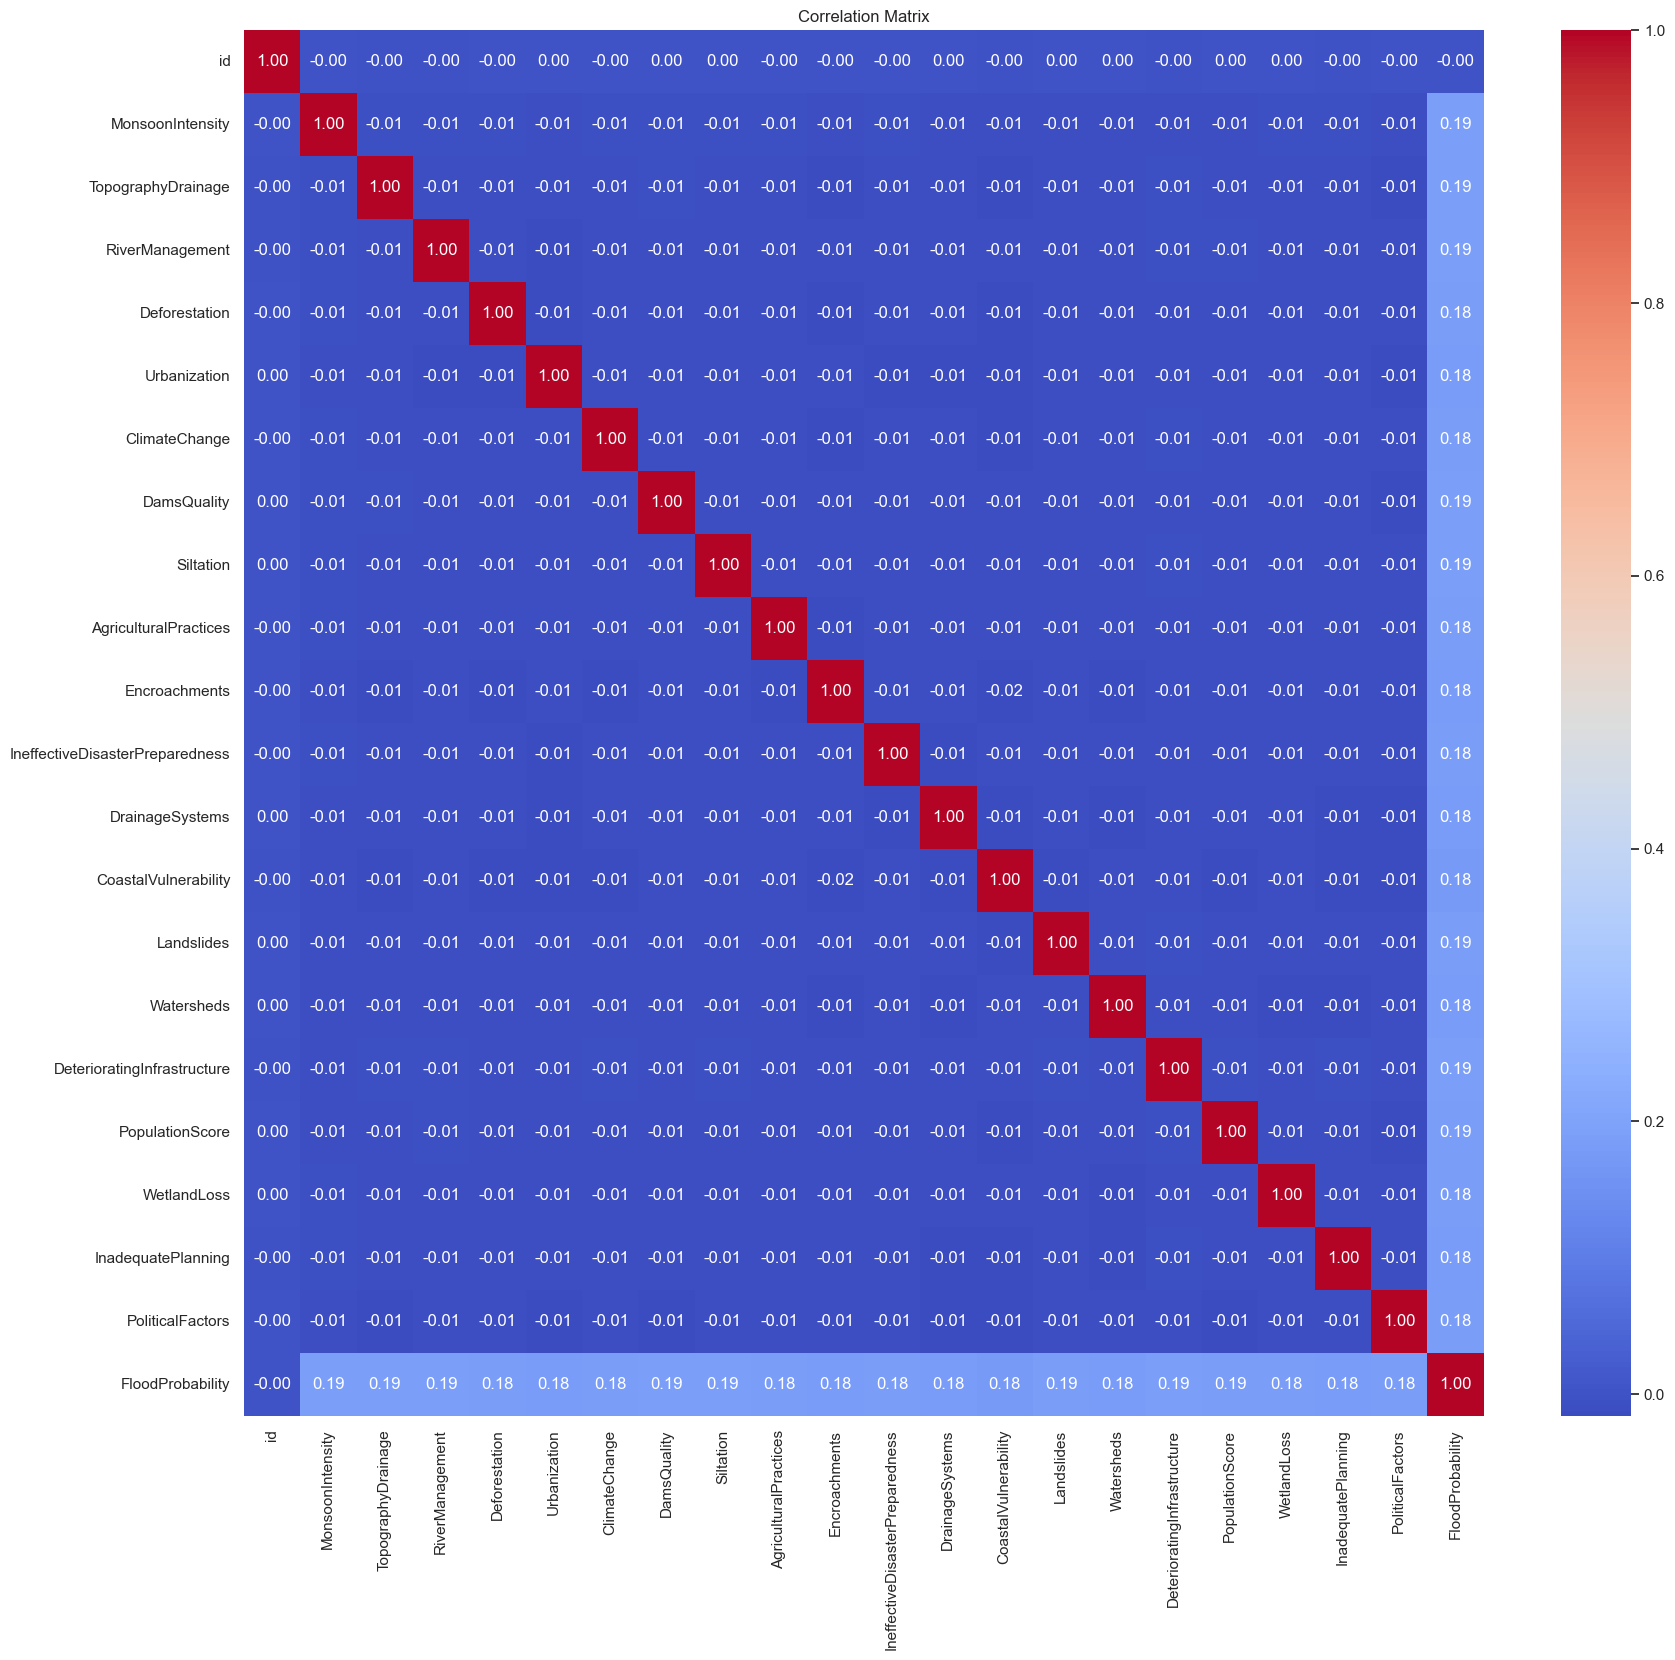

In [27]:
correlation_matrix = train.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

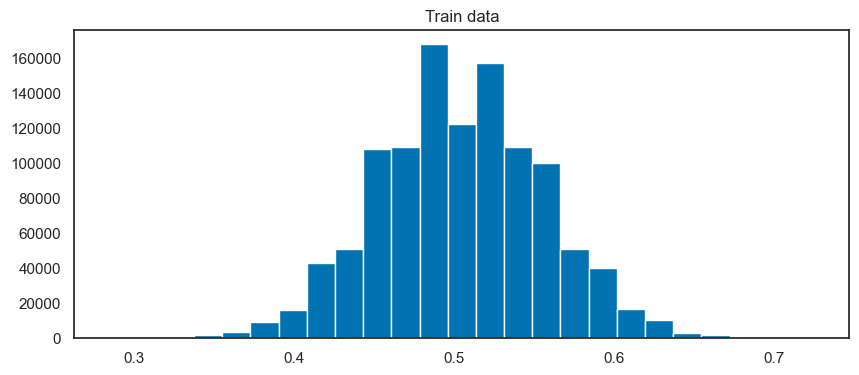

In [28]:
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=25)
plt.title("Train data")
plt.show()

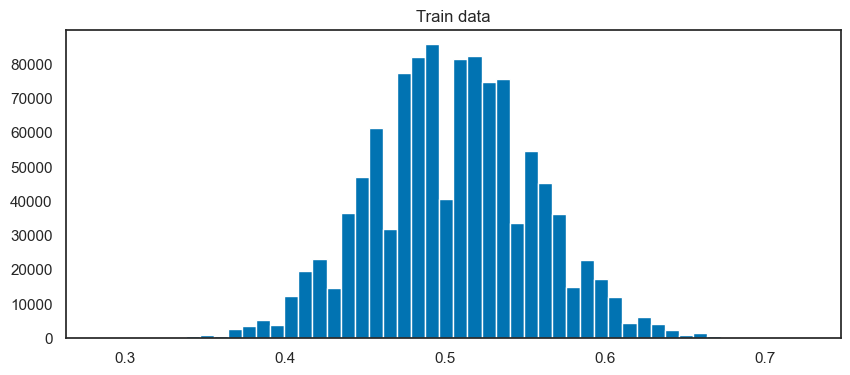

In [29]:
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=50)
plt.title("Train data")
plt.show()

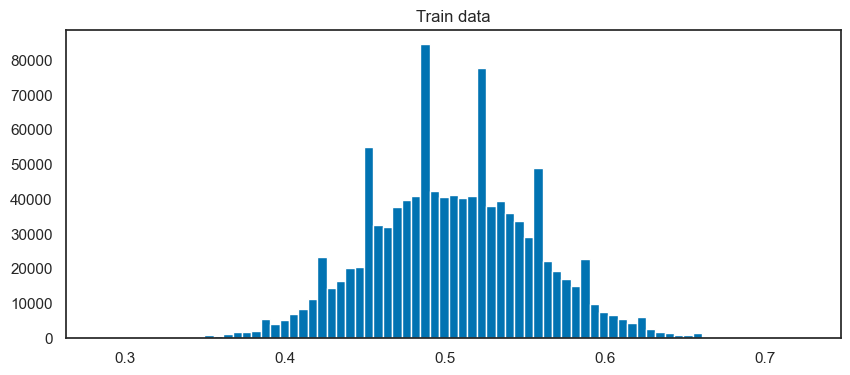

In [30]:
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=75)
plt.title("Train data")
plt.show()

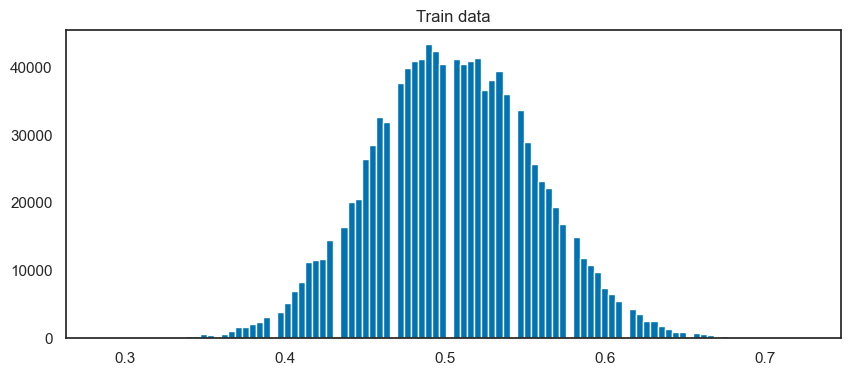

In [31]:
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=100)
plt.title("Train data")
plt.show()

In [32]:
stat = Statistic(train,False)
GT(stat)\
    .tab_header(title='Descriptive Statistic - Train', subtitle='Numeric Fields')\
    .data_color(columns=['min','max','mean'],palette=['lightblue','lightcoral'],alpha=0.5)\
    .fmt_percent(columns=['%unique','%null'])

GT(_tbl_data=                             Column  skew     type    count  nunique  %unique  \
0                                id  0.00    int64  1117957  1117957   100.00   
19               InadequatePlanning  0.46    int64  1117957       17     0.00   
18                      WetlandLoss  0.44    int64  1117957       20     0.00   
17                  PopulationScore  0.45    int64  1117957       19     0.00   
16      DeterioratingInfrastructure  0.44    int64  1117957       18     0.00   
15                       Watersheds  0.45    int64  1117957       17     0.00   
14                       Landslides  0.43    int64  1117957       17     0.00   
13             CoastalVulnerability  0.44    int64  1117957       18     0.00   
12                  DrainageSystems  0.44    int64  1117957       18     0.00   
11  IneffectiveDisasterPreparedness  0.44    int64  1117957       17     0.00   
10                    Encroachments  0.46    int64  1117957       19     0.00   
9             AgriculturalPractices  0.42    int64  1117957       17     0.00   
8                         Siltation  0.45    int64  1117957       17     0.00   
7                       DamsQuality  0.44    int64  1117957       17     0.00   
6                     ClimateChange  0.43    int64  1117957       18     0.00   
5                      Urbanization  0.44    int64  1117957       18     0.00   
4                     Deforestation  0.43    int64  1117957       18     0.00   
3                   RiverManagement  0.43    int64  1117957       17     0.00   
2                TopographyDrainage  0.46    int64  1117957       19     0.00   
1                  MonsoonIntensity  0.44    int64  1117957       17     0.00   
20                 PoliticalFactors  0.44    int64  1117957       17     0.00   
21                 FloodProbability  0.05  float64  1117957       83     0.01   

    null  %null       mean        std   min        25%       50%        75%  \
0      0    0.0  558978.00  322726.53  0.00  279489.00  558978.0  838467.00   
19     0    0.0       4.94       2.08  0.00       3.00       5.0       6.00   
18     0    0.0       4.95       2.07  0.00       4.00       5.0       6.00   
17     0    0.0       4.93       2.07  0.00       3.00       5.0       6.00   
16     0    0.0       4.93       2.06  0.00       3.00       5.0       6.00   
15     0    0.0       4.93       2.08  0.00       3.00       5.0       6.00   
14     0    0.0       4.93       2.08  0.00       3.00       5.0       6.00   
13     0    0.0       4.95       2.09  0.00       3.00       5.0       6.00   
12     0    0.0       4.95       2.07  0.00       4.00       5.0       6.00   
11     0    0.0       4.95       2.08  0.00       3.00       5.0       6.00   
10     0    0.0       4.95       2.08  0.00       4.00       5.0       6.00   
9      0    0.0       4.94       2.07  0.00       3.00       5.0       6.00   
8      0    0.0       4.93       2.07  0.00       3.00       5.0       6.00   
7      0    0.0       4.96       2.08  0.00       4.00       5.0       6.00   
6      0    0.0       4.93       2.06  0.00       3.00       5.0       6.00   
5      0    0.0       4.94       2.08  0.00       3.00       5.0       6.00   
4      0    0.0       4.94       2.05  0.00       4.00       5.0       6.00   
3      0    0.0       4.96       2.07  0.00       4.00       5.0       6.00   
2      0    0.0       4.93       2.09  0.00       3.00       5.0       6.00   
1      0    0.0       4.92       2.06  0.00       3.00       5.0       6.00   
20     0    0.0       4.94       2.09  0.00       3.00       5.0       6.00   
21     0    0.0       0.50       0.05  0.28       0.47       0.5       0.54   

           max  
0   1117956.00  
19       16.00  
18       19.00  
17       18.00  
16       17.00  
15       16.00  
14       16.00  
13       17.00  
12       17.00  
11       16.00  
10       18.00  
9        16.00  
8        16.00  
7        16.00  
6        17.00  
5        17.00  
4        17.00  

In [33]:
stat = Statistic(test,False)
GT(stat)\
    .tab_header(title='Descriptive Statistic - Test', subtitle='Numeric Fields')\
    .data_color(columns=['min','max','mean'],palette=['lightblue','lightcoral'],alpha=0.5)\
    .fmt_percent(columns=['%unique','%null'])

GT(_tbl_data=                             Column  skew   type   count  nunique  %unique  \
0                                id -0.00  int64  745305   745305    100.0   
18                      WetlandLoss  0.43  int64  745305       20      0.0   
17                  PopulationScore  0.45  int64  745305       20      0.0   
16      DeterioratingInfrastructure  0.44  int64  745305       18      0.0   
15                       Watersheds  0.45  int64  745305       17      0.0   
14                       Landslides  0.42  int64  745305       17      0.0   
13             CoastalVulnerability  0.44  int64  745305       18      0.0   
12                  DrainageSystems  0.44  int64  745305       18      0.0   
11  IneffectiveDisasterPreparedness  0.45  int64  745305       17      0.0   
19               InadequatePlanning  0.45  int64  745305       17      0.0   
10                    Encroachments  0.45  int64  745305       18      0.0   
8                         Siltation  0.45  int64  745305       17      0.0   
7                       DamsQuality  0.44  int64  745305       17      0.0   
6                     ClimateChange  0.43  int64  745305       18      0.0   
5                      Urbanization  0.45  int64  745305       18      0.0   
4                     Deforestation  0.44  int64  745305       18      0.0   
3                   RiverManagement  0.41  int64  745305       17      0.0   
2                TopographyDrainage  0.46  int64  745305       18      0.0   
1                  MonsoonIntensity  0.44  int64  745305       17      0.0   
9             AgriculturalPractices  0.42  int64  745305       17      0.0   
20                 PoliticalFactors  0.44  int64  745305       17      0.0   

    null  %null        mean        std        min        25%        50%  \
0      0    0.0  1490609.00  215151.17  1117957.0  1304283.0  1490609.0   
18     0    0.0        4.95       2.07        0.0        4.0        5.0   
17     0    0.0        4.93       2.07        0.0        3.0        5.0   
16     0    0.0        4.93       2.07        0.0        3.0        5.0   
15     0    0.0        4.93       2.08        0.0        3.0        5.0   
14     0    0.0        4.93       2.08        0.0        3.0        5.0   
13     0    0.0        4.96       2.09        0.0        3.0        5.0   
12     0    0.0        4.94       2.07        0.0        4.0        5.0   
11     0    0.0        4.95       2.08        0.0        3.0        5.0   
19     0    0.0        4.94       2.08        0.0        3.0        5.0   
10     0    0.0        4.95       2.08        0.0        4.0        5.0   
8      0    0.0        4.93       2.07        0.0        3.0        5.0   
7      0    0.0        4.96       2.09        0.0        4.0        5.0   
6      0    0.0        4.93       2.06        0.0        3.0        5.0   
5      0    0.0        4.94       2.08        0.0        3.0        5.0   
4      0    0.0        4.95       2.05        0.0        4.0        5.0   
3      0    0.0        4.96       2.07        0.0        4.0        5.0   
2      0    0.0        4.93       2.09        0.0        3.0        5.0   
1      0    0.0        4.92       2.06        0.0        3.0        5.0   
9      0    0.0        4.95       2.07        0.0        3.0        5.0   
20     0    0.0        4.94       2.09        0.0        3.0        5.0   

          75%        max  
0   1676935.0  1863261.0  
18        6.0       22.0  
17        6.0       19.0  
16        6.0       17.0  
15        6.0       16.0  
14        6.0       16.0  
13        6.0       17.0  
12        6.0       17.0  
11        6.0       16.0  
19        6.0       16.0  
10        6.0       17.0  
8         6.0       16.0  
7         6.0       16.0  
6         6.0       17.0  
5         6.0       17.0  
4         6.0       17.0  
3         6.0       16.0  
2         6.0       17.0  
1         6.0       16.0  
9         6.0       16.0  
20        6.0       16.0  , _body=<great_tables._gt_

In [34]:
s = min_max_unique(train.drop(TARGET,axis=1),test)
GT(s)\
    .tab_header(title='Min Max Uniques', subtitle='Train and Test datasets')\
    .data_color(columns=['columns'],palette=['lightgray','lightgray'])
    

GT(_tbl_data=                            columns  min_train  min_test  max_train  max_test  \
0                                id          0   1117957    1117956   1863261   
1                  MonsoonIntensity          0         0         16        16   
2                TopographyDrainage          0         0         18        17   
3                   RiverManagement          0         0         16        16   
4                     Deforestation          0         0         17        17   
5                      Urbanization          0         0         17        17   
6                     ClimateChange          0         0         17        17   
7                       DamsQuality          0         0         16        16   
8                         Siltation          0         0         16        16   
9             AgriculturalPractices          0         0         16        16   
10                    Encroachments          0         0         18        17   
11  IneffectiveDisasterPreparedness          0         0         16        16   
12                  DrainageSystems          0         0         17        17   
13             CoastalVulnerability          0         0         17        17   
14                       Landslides          0         0         16        16   
15                       Watersheds          0         0         16        16   
16      DeterioratingInfrastructure          0         0         17        17   
17                  PopulationScore          0         0         18        19   
18                      WetlandLoss          0         0         19        22   
19               InadequatePlanning          0         0         16        16   
20                 PoliticalFactors          0         0         16        16   

    unique_train  unique_test  
0        1117957       745305  
1             17           17  
2             19           18  
3             17           17  
4             18           18  
5             18           18  
6             18           18  
7             17           17  
8             17           17  
9             17           17  
10            19           18  
11            17           17  
12            18           18  
13            18           18  
14            17           17  
15            17           17  
16            18           18  
17            19           20  
18            20           20  
19            17           17  
20            17           17  , _body=<great_tables._gt_data.Body object at 0x0000023B8194E8D0>, _boxhead=Boxhead([ColInfo(var='columns', type=<ColInfoTypeEnum.default: 1>, column_label='columns', column_align='left', column_width=None), ColInfo(var='min_train', type=<ColInfoTypeEnum.default: 1>, column_label='min_train', column_align='right', column_width=None), ColInfo(var='min_test', type=<ColInfoTypeEnum.default: 1>, column_label='min_test', column_align='right', column_width=None), ColInfo(var='max_train', type=<ColInfoTypeEnum.default: 1>, column_label='max_train', column_align='right', column_width=None), ColInfo(var='max_test', type=<ColInfoTypeEnum.default: 1>, column_label='max_test', column_align='right', column_width=None), ColInfo(var='unique_train', type=<ColInfoTypeEnum.default: 1>, column_label='unique_train', column_align='right', column_width=None), ColInfo(var='unique_test', type=<ColInfoTypeEnum.default: 1>, column_label='unique_test', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6,

In [55]:
def plot_correlation(df,label=''):
    corr = df._get_numeric_data().corr(method='spearman')
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)]=True
    fig, ax = plt.subplots(figsize=(25,17))
    sns.heatmap(data=corr, 
                mask=mask,annot=True,
                cmap='icefire',annot_kws={'size': 12, 'rotation': 45},
                ax=ax,linewidths=.5
                )
    ax.set_title(f'Correlation {label}',fontsize=25, fontweight='bold')

In [57]:
plot_correlation(train,'Train')